# From Eh to Brie: A Mooving Exploration of Canadian Cheese

## Introduction

The goal of this project will be to use machine learning techniques to predict the fat content (high or low) in various cheeses using the cheese_data.csv provided. Since the target is relatively straight forward and the features are somewhat limited,  I expect the model to do quite well with an high degree of accuracy (hoping for >80%). I will focus on accuracy as the main scoring metric since there are no health outcomes from classifying the right/wrong class. If there was a health reason why someone would want high or low fat cheese, I would consider prioritizing recall over accuracy as this would look to minimize the false negatives/positives.

This type of problem will be best solved as a classification problem since we are predicting if something is 'high' or 'low' (labels) fat content, not a numeric value of the actual fat content - which would be a regression model.

I will use both Random Forest and Logistic Regression for this problem, assessing the results to understand which model is more suitable.


## Exploratory Data Analysis

We will bring in the appropriate libraries

In [1]:
import pandas as pd
import altair as alt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt

import plotly.graph_objects as go


Lets start by reading in the data

In [2]:
cheese_df = pd.read_csv('data/cheese_data.csv')
cheese_df

CheeseId ManufacturerProvCode ManufacturingTypeEn  MoisturePercent  \
0          228                   NB           Farmstead             47.0   
1          242                   NB           Farmstead             47.9   
2          301                   ON          Industrial             54.0   
3          303                   NB           Farmstead             47.0   
4          319                   NB           Farmstead             49.4   
...        ...                  ...                 ...              ...   
1037      2387                   NS           Farmstead             37.0   
1038      2388                   AB          Industrial             46.0   
1039      2389                   NS             Artisan             40.0   
1040      2390                   NS             Artisan             34.0   
1041      2391                   AB             Artisan             31.5   

                                              FlavourEn  \
0                                         Sharp, lactic   
1                    Sharp, lactic, lightly caramelized   
2                               Mild, tangy, and fruity   
3      Sharp with fruity notes and a hint of wild honey   
4                                          Softer taste   
...                                                 ...   
1037  Dill, Caraway, Chili Pepper, Cumin, Sage, Chiv...   
1038                               Mild and Deep Flavor   
1039  Grassy tang and restrained saltiness that refl...   
1040  Sweet and tangy flavours combine with hoppy no...   
1041  Available in different flavor: original, herb ...   

                                      CharacteristicsEn  Organic  \
0                                              Uncooked        0   
1                                              Uncooked        0   
2     Pressed and cooked cheese, pasta filata, inter...        0   
3                                                   NaN        0   
4                                                   NaN        1   
...                                                 ...      ...   
1037  Fresh curds through a variety of added Organic...        1   
1038                              Low in Sodium and Fat        0   
1039                                                NaN        0   
1040                                                NaN        0   
1041                         Soft Squeaky Fresh Cheese.        0   

        CategoryTypeEn MilkTypeEn MilkTreatmentTypeEn   RindTypeEn  \
0          Firm Cheese        Ewe            Raw Milk  Washed Rind   
1     Semi-soft Cheese        Cow            Raw Milk  Washed Rind   
2          Firm Cheese        Cow         Pasteurized          NaN   
3       Veined Cheeses        Cow            Raw Milk          NaN   
4     Semi-soft Cheese        Cow            Raw Milk  Washed Rind   
...                ...        ...                 ...          ...   
1037       Hard Cheese        Cow         Pasteurized          NaN   
1038      Fresh Cheese        Cow         Pasteurized          NaN   
1039    Veined Cheeses        Ewe           Thermised          NaN   
1040  Semi-soft Cheese        Ewe           Thermised  Washed Rind   
1041      Fresh Cheese        Cow         Pasteurized      No Rind   

                              CheeseName    FatLevel  
0                Sieur de Duplessis (Le)   lower fat  
1                    Tomme Le Champ Doré   lower fat  
2     Provolone Sette Fette (Tre-Stelle)   lower fat  
3                         Geai Bleu (Le)   lower fat  
4                             Gamin (Le)   lower fat  
...                                  ...         ...  
1037                            Knoydart  higher fat  
1038                             FRESK-O   lower fat  
1039                       Electric Blue  higher fat  
1040                             Hip Hop  higher fat  
1041            Super Fresh Cheese Curds  higher fat  

[1042 rows x 13 columns]

Lets take a look at the datatypes for each for

In [3]:
cheese_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              1042 non-null   int64  
 1   ManufacturerProvCode  1042 non-null   object 
 2   ManufacturingTypeEn   1042 non-null   object 
 3   MoisturePercent       1028 non-null   float64
 4   FlavourEn             801 non-null    object 
 5   CharacteristicsEn     643 non-null    object 
 6   Organic               1042 non-null   int64  
 7   CategoryTypeEn        1019 non-null   object 
 8   MilkTypeEn            1041 non-null   object 
 9   MilkTreatmentTypeEn   977 non-null    object 
 10  RindTypeEn            721 non-null    object 
 11  CheeseName            1042 non-null   object 
 12  FatLevel              1042 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 106.0+ KB


In [4]:
cheese_df.describe()

CheeseId  MoisturePercent      Organic
count  1042.000000      1028.000000  1042.000000
mean   1560.633397        47.069747     0.095010
std     451.811164         9.592647     0.293369
min     228.000000        12.000000     0.000000
25%    1280.250000        40.000000     0.000000
50%    1548.500000        46.000000     0.000000
75%    1901.750000        52.000000     0.000000
max    2391.000000        92.000000     1.000000

To better understand the data, lets take a look at a couple of visuals 

In [47]:
moisture_chart = alt.Chart(cheese_df).mark_bar().encode(
    alt.X('MoisturePercent:Q', bin=alt.Bin(maxbins=20), title='Moisture Content'),
    alt.Y('count()', title='Count'),
    alt.Color('CategoryTypeEn:N', title='Cheese Category'),
    tooltip=['MoisturePercent', 'CategoryTypeEn', 'count()']
).properties(
    title='Chart 1: Moisture Content Distribution by Cheese Category'
)

# Visualization 2: Manufacturing Types and Organic Status
manufacturing_chart = alt.Chart(cheese_df).mark_bar().encode(
    alt.X('ManufacturingTypeEn:N', title='Manufacturing Type'),
    alt.Y('count()', title='Count'),
    alt.Color('Organic:N', title='Organic Status', scale=alt.Scale(scheme='tableau10'), legend=alt.Legend(title='Organic')),
    tooltip=['ManufacturingTypeEn', 'Organic', 'count()']
).properties(
    title='Chart 2: Manufacturing Types and Organic Status'
)

# Display the visualizations
moisture_chart | manufacturing_chart


alt.HConcatChart(...)

Looking at the moisture content, we can see that the main distribution of moisture content is >35 and <60. We can also see that veined cheese mostly has between 40 and 50 moisture content and soft cheese mostley between 50 and 60 moisture content.

Looking at the organic status's of cheese, we see, unsurprisingly, that the majority of industrially manufactured cheese is not organic. Farmstead has the highest proportion of organic cheeses with artisan behind that.
Overall, industrial produces the most amount of cheese with farmstead, the least.

After exploring the data, I can see that the majority of data is non numeric, meaning that it will needing some processing to turn it into something useful for ML. Many of the columns have null values and so I will need to review each one of those and determine the most appropriate way to deal with that.

The fat level of the cheese looks like it would be a suitable candidate for the target data.

In [48]:
fat_chart = alt.Chart(cheese_df).mark_bar().encode(
    alt.X('MilkTypeEn:N', title='Milk Type', sort=alt.EncodingSortField(field='count', op='sum', order='descending')),
    alt.Y('count()', title='Count'),
    alt.Color('FatLevel:N', title='Fat Level'),
    tooltip=['MilkTypeEn', 'FatLevel', 'count()']
).properties(
    title='Chart 3: Fat Content Distribution by Milk Type'
)


# Display the visualization
fat_chart


alt.Chart(...)

## Relanships between Features
Cow cheese makes up the majority of the dataset - and also the majority of the higher fat cheeses.
There is about double the lower fat count than higher fat count in the data, with Cow cheese having significantly higher fat counts then Goat cheese.

Lets take a look at the percentages of high to low fat by the milk type.

In [7]:
fat_level_counts = cheese_df.groupby(['MilkTypeEn', 'FatLevel']).size().unstack(fill_value=0)

# Calculate the percentage of higher fat cheeses
fat_level_counts['High Fat Ratio %'] = round((fat_level_counts['higher fat'] / (fat_level_counts['higher fat'] + fat_level_counts['lower fat'])) * 100, 2)

# Display the resulting DataFrame with the new column
result = fat_level_counts.sort_values(by='High Fat Ratio %', ascending=False)

# Display the result
print(result)

FatLevel           higher fat  lower fat  High Fat Ratio %
MilkTypeEn                                                
Ewe and Cow                 3          1             75.00
Ewe and Goat                1          1             50.00
Cow                       297        446             39.97
Ewe                        24         38             38.71
Cow and Goat                3         10             23.08
Goat                       29        185             13.55
Buffalo Cow                 0          2              0.00
Cow, Goat and Ewe           0          1              0.00


Cow cheese has the highest count (about 10x more) then the second place, of higher fat cheeses. 

In [8]:
cheese_df['FatLevel'].value_counts()

lower fat     684
higher fat    358
Name: FatLevel, dtype: int64

Given that the data is slighlty imbalanced, we will have to keep this in mind while processing and see how this impacts the predictions - however, the dataset is not dramatically imbalanced.

Now that we have been able to explore the data, it will be good to review which metrics should be used to evaluate the success of the project. Below are brief explanations of the scores. 

<b> Accuracy</b> : This measures the proportion of correctly classified observations out of the total observations. This can be misleading if the classes are imbalanced - which we have seen in the above analysis, is not the case. 

<b>Precision</b>: Precision measures the proportion of true positives out of all instances classified. It's a measure of the accuracy of positive predictions.

<b>Recall </b>: Recall measures the proportion of true positives identified correctly out of all actual instances. It's a measure of the model's ability to find all the relevant cases within a dataset.

<b>F1 Score</b>: This is the mean of precision and recall. It's useful when you want to seek a balance between false positives and false negatives.

Since with this problem, it is not essential to capture a certain type of cheese (i.e. if this model was to help someone reduce their fat intake, this would be more of a consideration and I would likely prioritize Recall), I believe that Accuracy will be the best as the data isn't heavily imbalanced. I will review the others scores also but will base the best models on Accuracy.

<b>Confusion Matrix</b>: The confusion matrix provides a comprehensive view of the model's performance by showing the counts of true positives, true negatives, false positives, and false negatives.

## Challenges of the data
Some of the columns are text which would require count vectorizing. I am choosing to leave these columns out for now but will consider it as a potential for optimizing the model in the future.
## Inconsistancies in the data
There are some null data points which I have addressed below using techniques such as using the median values (for a numeric value) or labelling a missing value as missing (in the case of a categorical feature).
## Missing Data 
Below is the missing data by count and % of columns.

In [9]:
null_data = cheese_df.isnull().sum()

# Display the null data
print(f'''
************* Null Value Counts *************
{null_data}
*********************************************'''
)

# Display the percentage of null values for each column
null_percentage = round((cheese_df.isnull().sum() / len(cheese_df)) * 100, 2)
print(f'''
************* Null % of Column *************
{null_percentage}
********************************************
''')


************* Null Value Counts *************
CheeseId                  0
ManufacturerProvCode      0
ManufacturingTypeEn       0
MoisturePercent          14
FlavourEn               241
CharacteristicsEn       399
Organic                   0
CategoryTypeEn           23
MilkTypeEn                1
MilkTreatmentTypeEn      65
RindTypeEn              321
CheeseName                0
FatLevel                  0
dtype: int64
*********************************************

************* Null % of Column *************
CheeseId                 0.00
ManufacturerProvCode     0.00
ManufacturingTypeEn      0.00
MoisturePercent          1.34
FlavourEn               23.13
CharacteristicsEn       38.29
Organic                  0.00
CategoryTypeEn           2.21
MilkTypeEn               0.10
MilkTreatmentTypeEn      6.24
RindTypeEn              30.81
CheeseName               0.00
FatLevel                 0.00
dtype: float64
********************************************



We can see that some of these columns have a significant amount of null values, though nothing is over 50% null data. So therefore, we should consider, do we throw away that column altogether or do we look to keep the data and impute the missing data? If the missing data % for a potential feature were over 50%, I would consider dropping it, but in this case, they are all less then 50%, so I will look to impute missing values where neccessary. 

## Feature Selection

Now that we have explored the data and can see data types, missing percentages etc, we can look to select the features which we will use on this dataset.

In [10]:
print(cheese_df.describe())
print(cheese_df.info())
cheese_df.head()

          CheeseId  MoisturePercent      Organic
count  1042.000000      1028.000000  1042.000000
mean   1560.633397        47.069747     0.095010
std     451.811164         9.592647     0.293369
min     228.000000        12.000000     0.000000
25%    1280.250000        40.000000     0.000000
50%    1548.500000        46.000000     0.000000
75%    1901.750000        52.000000     0.000000
max    2391.000000        92.000000     1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              1042 non-null   int64  
 1   ManufacturerProvCode  1042 non-null   object 
 2   ManufacturingTypeEn   1042 non-null   object 
 3   MoisturePercent       1028 non-null   float64
 4   FlavourEn             801 non-null    object 
 5   CharacteristicsEn     643 non-null    object 
 6   Organic               1042 non-null   i

CheeseId ManufacturerProvCode ManufacturingTypeEn  MoisturePercent  \
0       228                   NB           Farmstead             47.0   
1       242                   NB           Farmstead             47.9   
2       301                   ON          Industrial             54.0   
3       303                   NB           Farmstead             47.0   
4       319                   NB           Farmstead             49.4   

                                          FlavourEn  \
0                                     Sharp, lactic   
1                Sharp, lactic, lightly caramelized   
2                           Mild, tangy, and fruity   
3  Sharp with fruity notes and a hint of wild honey   
4                                      Softer taste   

                                   CharacteristicsEn  Organic  \
0                                           Uncooked        0   
1                                           Uncooked        0   
2  Pressed and cooked cheese, pasta filata, inter...        0   
3                                                NaN        0   
4                                                NaN        1   

     CategoryTypeEn MilkTypeEn MilkTreatmentTypeEn   RindTypeEn  \
0       Firm Cheese        Ewe            Raw Milk  Washed Rind   
1  Semi-soft Cheese        Cow            Raw Milk  Washed Rind   
2       Firm Cheese        Cow         Pasteurized          NaN   
3    Veined Cheeses        Cow            Raw Milk          NaN   
4  Semi-soft Cheese        Cow            Raw Milk  Washed Rind   

                           CheeseName   FatLevel  
0             Sieur de Duplessis (Le)  lower fat  
1                 Tomme Le Champ Doré  lower fat  
2  Provolone Sette Fette (Tre-Stelle)  lower fat  
3                      Geai Bleu (Le)  lower fat  
4                          Gamin (Le)  lower fat

We don't need the CheeseID column as this is just an identifier so I will drop this. The new index will serve the same purpose.

FlavourEn, CharacteristicsEn, RindTypeEn and CheeseName could all be used with CountVectorizer, however, for the first run I have left it out of this model and will drop this.

In [11]:
cheese_modified_df = cheese_df.copy()
cheese_modified_df.drop(columns={'CheeseId','FlavourEn', 'CharacteristicsEn', 'RindTypeEn', 'CheeseName'},
                       inplace=True)
print(cheese_modified_df.info())
cheese_modified_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  1042 non-null   object 
 1   ManufacturingTypeEn   1042 non-null   object 
 2   MoisturePercent       1028 non-null   float64
 3   Organic               1042 non-null   int64  
 4   CategoryTypeEn        1019 non-null   object 
 5   MilkTypeEn            1041 non-null   object 
 6   MilkTreatmentTypeEn   977 non-null    object 
 7   FatLevel              1042 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 65.2+ KB
None


ManufacturerProvCode ManufacturingTypeEn  MoisturePercent  Organic  \
0                   NB           Farmstead             47.0        0   
1                   NB           Farmstead             47.9        0   
2                   ON          Industrial             54.0        0   
3                   NB           Farmstead             47.0        0   
4                   NB           Farmstead             49.4        1   

     CategoryTypeEn MilkTypeEn MilkTreatmentTypeEn   FatLevel  
0       Firm Cheese        Ewe            Raw Milk  lower fat  
1  Semi-soft Cheese        Cow            Raw Milk  lower fat  
2       Firm Cheese        Cow         Pasteurized  lower fat  
3    Veined Cheeses        Cow            Raw Milk  lower fat  
4  Semi-soft Cheese        Cow            Raw Milk  lower fat

Now that we have explored the data and have an understanding of what some of the challenges might be, we should split the dataset into test and train and start preprocessing.

## Splitting the data

I will keep 20% of the data as the testing size.

In [12]:
train_df, test_df = train_test_split(cheese_modified_df, test_size=0.2, random_state=1989)

Then I will seperate the X and Y.

In [13]:
X_columns = ['ManufacturerProvCode'
            , 'ManufacturingTypeEn'
            , 'MoisturePercent'
            , 'Organic'
            , 'CategoryTypeEn'
            , 'MilkTypeEn'
            , 'MilkTreatmentTypeEn'
           ]
y_column =['FatLevel']

X_train = train_df[X_columns]
y_train = train_df[y_column]

X_test = test_df[X_columns]
y_test = test_df[y_column]


## Catogorical, numeric and binary selection

The columns should be split into catagorical, binary and numeric segments to take advantage of pipeline processing, one-hot encoding, scaling and imputing.

Below I have selected the appropriate columns for the feature types.

In [14]:
categorical_features = [
    'ManufacturerProvCode'
    , 'ManufacturingTypeEn'
    , 'CategoryTypeEn'
    , 'MilkTypeEn'
    , 'MilkTreatmentTypeEn'
            
]

numeric_features = [
    'MoisturePercent'
]

binary_features = [
    'Organic'
]

The data has been selected this way as there MoisturePercent is the only numeric feature, Organic the only binary feature and the rest are categorical. If we wanted to avoid numeric and binary, we could consider making them categorical but I am not sure that would be beneficial to the model.

Now I need to create pipelines for each of the segments and determine how I will deal with missing values.


Lets take a look at the numeric features

In [15]:
cheese_modified_df[numeric_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MoisturePercent  1028 non-null   float64
dtypes: float64(1)
memory usage: 8.3 KB


For numeric, I have decided to use the strategy = 'median' with the SimpleImputer. Given that the only column which is numeric is MoisturePercent and there a majority of non-null values, this seems reasonable. For scaling I will use the default StandardScaler.



Lets take a look at the categorical features

In [16]:
cheese_modified_df[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ManufacturerProvCode  1042 non-null   object
 1   ManufacturingTypeEn   1042 non-null   object
 2   CategoryTypeEn        1019 non-null   object
 3   MilkTypeEn            1041 non-null   object
 4   MilkTreatmentTypeEn   977 non-null    object
dtypes: object(5)
memory usage: 40.8+ KB


With the categorical features, for the SimpleImputer, I will use strategy='constant' and fill it with the values 'missing'. The majority of data is there for each of the columns and it doesn't seem like dropping the columns would be beneficial as a significant amount of the data would be lost. For scaling I will use the default StandardScaler.

Lets take a look at the binary data

In [17]:
cheese_modified_df[binary_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Organic  1042 non-null   int64
dtypes: int64(1)
memory usage: 8.3 KB


In [18]:
cheese_modified_df[binary_features].value_counts()

Organic
0          943
1           99
dtype: int64

There is full coverage of the binary data with all the data being truly binary. I will still however pass the binary features through the OneHotEncoder with drop='if_binary'  as a best practice. drop='if_binary' drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.



## Dummy Classifier

Prior to creating a pipeline, it would be a good idea to do a DummyClassifier as a base model to see how well we perform.

In [19]:
dummy = DummyClassifier(strategy='most_frequent')
dummy_scores = pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True))
dummy_scores.mean()

fit_time       0.001558
score_time     0.000712
test_score     0.650660
train_score    0.650660
dtype: float64

The results from the dummy classifier predicting the most frequent target give me a score of around ~65%. I should aim to beat this score.

## Creating a pipeline

Now I will make the feature transformers for each feature type and I will make use of the make_column_transformer function to reduce the code for the ColumnTransformer function.

Note that the pipeline will use the LogisticRegression model here and I will look to use the RandomizedSearchCV after to tune the parameter C.

I will also have to make sure that the categorical types are all present for cross validation otherwise I will get errors. To do this, I will use the handle_unknown='ignore' parameter which will 0 out the columns if they are unknown.

In [20]:
numeric_transformer = make_pipeline(SimpleImputer(strategy='median')
                                   , StandardScaler())

categorical_transformer = make_pipeline(SimpleImputer(strategy='constant'
                                                     , fill_value='missing')
                                       , OneHotEncoder(handle_unknown='ignore'))

binary_transformer = make_pipeline(
    OneHotEncoder(drop='if_binary')
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (binary_transformer, binary_features))



Now that the pipeline has been created, lets look at applying models to it and tuning the hyperparemeters to see how we do.

## Logistic Regression

In [21]:
pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))

Lets look at tuning the C parameter using random_search. Since I am going to look at multiple scoring parameters, I am going to set refit=False. I will not be using the best model quite yet.

In [22]:
param_grid = {
    "logisticregression__C": loguniform(0.01, 100)
}

pos_label = 'higher fat'

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=pos_label),
    'recall': make_scorer(recall_score, pos_label=pos_label),
    'f1': make_scorer(f1_score, pos_label=pos_label)
}

logistict_regression_random_search = RandomizedSearchCV(pipe
                                   ,param_distributions=param_grid
                                   ,n_iter=10
                                   ,cv=5
                                   ,n_jobs=-1
                                   ,verbose=3
                                   ,return_train_score=True
                                   ,scoring=scoring
                                   ,refit='accuracy'
                                   ,random_state=1987
                                  )

logistict_regression_random_search.fit(X_train, np.ravel(y_train))
# random_search.fit(X_train, y_train)
# random_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END logisticregression__C=0.08256268462267681; accuracy: (train=0.794, test=0.772) f1: (train=0.685, test=0.648) precision: (train=0.738, test=0.700) recall: (train=0.639, test=0.603) total time=   0.0s
[CV 2/5] END logisticregression__C=0.08256268462267681; accuracy: (train=0.803, test=0.707) f1: (train=0.702, test=0.559) precision: (train=0.748, test=0.585) recall: (train=0.661, test=0.534) total time=   0.0s
[CV 3/5] END logisticregression__C=0.08256268462267681; accuracy: (train=0.778, test=0.784) f1: (train=0.661, test=0.679) precision: (train=0.706, test=0.717) recall: (train=0.621, test=0.644) total time=   0.0s
[CV 4/5] END logisticregression__C=0.08256268462267681; accuracy: (train=0.801, test=0.807) f1: (train=0.691, test=0.709) precision: (train=0.753, test=0.750) recall: (train=0.639, test=0.672) total time=   0.0s
[CV 5/5] END logisticregression__C=0.08256268462267681; accuracy: (train=0.786, test=0.825)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                 

Now that the model has been fitted and a randomized search has been performed, we can see what the optimal C parameter was.

In [23]:
best_c = logistict_regression_random_search.best_params_['logisticregression__C']
best_c

0.016611388027175766

We can also look to see what the best score was.

In [24]:
logistic_regression_best_score = logistict_regression_random_search.best_score_
logistic_regression_best_score

0.7959743164273861

Using classes_, we can determine that the positive class is in index 1 of the array

In [25]:
logistict_regression_random_search.classes_

array(['higher fat', 'lower fat'], dtype=object)

Lets take a look at the mean scores of the random search 

In [26]:
cv_results = logistict_regression_random_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)
cv_results_sorted_df = cv_results_df[['param_logisticregression__C','mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']].sort_values(by='mean_test_accuracy', ascending=False)
cv_results_sorted_df

param_logisticregression__C  mean_test_accuracy  mean_test_precision  \
5                    0.016611            0.795974             0.811094   
1                    0.018905            0.791169             0.789532   
9                    0.048137            0.782801             0.728164   
7                    0.278176            0.780405             0.710109   
0                    0.082563            0.779201             0.717819   
6                    0.091521            0.779201             0.714957   
4                    0.618208            0.774381             0.692541   
8                    1.178111            0.774367             0.691582   
2                    6.872402            0.768364             0.681026   
3                    8.615359            0.767160             0.678300   

   mean_test_recall  mean_test_f1  
5          0.549795      0.653756  
1          0.556634      0.651419  
9          0.611572      0.663950  
7          0.632086      0.668102  
0          0.615020      0.661448  
6          0.618469      0.662376  
4          0.635535      0.662561  
8          0.635476      0.661985  
2          0.628580      0.653561  
3          0.628580      0.652307

From the dataframe, we can see that a value of C = 0.016611 has the best accuracy and precision score. There is not much difference across the board for the mean f1 scores but there was quite a swing for the recall scored with this particular top scoring model (based on accuracy), scoring the lowest for recall. Recall (sensitivity) measures the proportion of true positive predictions. Since with this problem, it is not essential to capture a certain type of cheese (i.e. if this model was to help someone reduce their fat intake, this would be more of a consideration), I will focus on the model with the highest accuracy. 


Lets take a look at the coefficients of this model by using the best C parameter from the search, fitting the model, then extracting the coefficients and the names from the data. We will then put these into a dataframe.

In [27]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, C=best_c))

lr_pipe.fit(X_train, np.ravel(y_train))

logistic_model = lr_pipe.named_steps['logisticregression']

lr_coeffs = logistic_model.coef_
len(lr_coeffs)

new_cat_cols = lr_pipe.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder'].get_feature_names(categorical_features)
feature_list = np.concatenate([numeric_features, new_cat_cols, binary_features])
# len(feature_list)
# lr_coeffs[0]
feature_coeff_df = pd.DataFrame(data=lr_coeffs[0], index=feature_list, columns=['Coefficients'])
feature_coeff_df.sort_values('Coefficients', ascending=False)

Coefficients
MoisturePercent                      0.849102
MilkTypeEn_Goat                      0.247595
MilkTreatmentTypeEn_Pasteurized      0.198413
CategoryTypeEn_Semi-soft Cheese      0.164241
ManufacturerProvCode_NB              0.076961
CategoryTypeEn_Fresh Cheese          0.071825
CategoryTypeEn_missing               0.040014
ManufacturingTypeEn_Farmstead        0.036479
ManufacturerProvCode_MB              0.035274
ManufacturingTypeEn_Industrial       0.030834
CategoryTypeEn_Hard Cheese           0.021253
ManufacturerProvCode_ON              0.013446
CategoryTypeEn_Veined Cheeses        0.008017
MilkTypeEn_Cow, Goat and Ewe         0.003729
MilkTypeEn_Buffalo Cow               0.001126
MilkTreatmentTypeEn_missing          0.000819
ManufacturerProvCode_AB             -0.003259
MilkTypeEn_Cow and Goat             -0.003315
ManufacturerProvCode_PE             -0.004899
MilkTypeEn_Ewe and Goat             -0.005061
ManufacturerProvCode_NS             -0.006120
ManufacturerProvCode_QC             -0.007208
ManufacturerProvCode_NL             -0.007595
MilkTypeEn_missing                  -0.009420
MilkTypeEn_Ewe and Cow              -0.017020
CategoryTypeEn_Soft Cheese          -0.026554
Organic                             -0.046879
ManufacturingTypeEn_Artisan         -0.067309
MilkTreatmentTypeEn_Thermised       -0.068864
MilkTypeEn_Ewe                      -0.070029
ManufacturerProvCode_BC             -0.096597
MilkTreatmentTypeEn_Raw Milk        -0.130364
MilkTypeEn_Cow                      -0.147601
CategoryTypeEn_Firm Cheese          -0.278793

Recall that by looking at the classes_ we can confirm which is the positive class as it will be in index 1 of the array - which in this case is the 'lower fat' class.

In [28]:
logistic_model.classes_

array(['higher fat', 'lower fat'], dtype=object)

Keeping in mind the following:

Positive Coefficient - indicates that an increase in the predictor variable is associated with an increase in the log odds of the positive class (or a decrease in the log odds of the negative class). In other words, higher values of the feature are associated with a higher likelihood of belonging to the positive class (lower fat in this case).

Negative Coefficient - indicates that an increase in the predictor variable is associated with a decrease in the log odds of the positive class (or an increase in the log odds of the negative class). In other words, higher values of the feature are associated with a lower likelihood of belonging to the positive class (lower fat in this case).

The data therefore suggests a stronger correlation of the MoisturePercent when predicting the class 'lower fat', while the feature CategoryTypeEn_Firm Cheese tells us that an increase in this value is associated with a decrease in the odds of predicting 'lower fat' - or in othewr words, an increase in CategoryTypeEn_Firm Cheese makes these cheese more likely to be a 'higher fat' prediction.

This wasn't something that I had anticipated earlier and I didn't create any visualization on it. I will therefore take a look to see if there is a visible correlation between moisture content and fat

In [49]:
cheese_df['FatLevel'] = cheese_df['FatLevel'].astype('category')

# Create the Altair chart
chart = alt.Chart(cheese_df).mark_boxplot().encode(
    x=alt.X('FatLevel:N', title='Fat Level'),
    y=alt.Y('MoisturePercent:Q', title='Moisture Percent')
).properties(
    width=400,
    height=300,
    title = 'Chart 4: Fat Level by Moisture Percent'
)

# Show the chart
chart


alt.Chart(...)

The visualisation does indeed show a correlation of higher moisture percentage cheeses tending to be lower in fat.

Perhaps a cruder way to see the same data would be looking at the mean moisture percentage by the fat levels

In [30]:
mean_moisture_by_fat_level = cheese_df.groupby('FatLevel')['MoisturePercent'].mean().reset_index()
mean_moisture_by_fat_level

FatLevel  MoisturePercent
0  higher fat        40.543539
1   lower fat        50.527083

Lets take a look at a confusion matrix of the results to se how the predictions did.

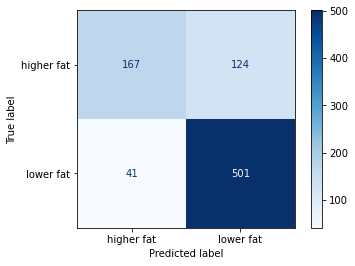

In [31]:
lr_confusion_matrix = plot_confusion_matrix(lr_pipe, X_train, y_train, display_labels=['higher fat','lower fat'], values_format='d', cmap='Blues')
lr_confusion_matrix

The accuracy for this is ~80% which is slightly better then the mean cross validation score.

In [32]:
lr_accuracy = (501+167)/833
lr_accuracy

0.801920768307323

For this matrix, the positive class is the lower fat.
The confusion matric shows:
- True Negative (true:higher fat, predicted:higher fat) of 167 - The negative class which we predicted correctly.
- True Positive (true:lower fat, predicted:lower fat) of 501 - The positive class which we predicted correctly.
- False Positives (true:higher fat, predicted:lower fat) of 124 - The positive class which we predicted incorrectly.
- False Negatives (true:lower fat, predicted:higher fat) of 41 - The negative class which we predicted incorrectly.

The model correctly predicts a significant amount of lower fat 501 out of 542 - this is about 92.5% which is quite good. The model does struggle with the higher fat in comparrison - correctly predicting 167 out of 291 ~57% . Given that the model is tuned for accuracy, this is fine. However, as previously mentioned, if the model was to assist in dietary needs, and therefore had health implications, I would have focussed more on recall in the hyper parameter tuning stage and would have liked to see a significant shift lower in the false positives.



## Decision Tree

Now that I have explored the Logistic Regression model, I want to look at the decision tree. Below, I will use the steps already defined above from the preprocessor, and will bring in the DecisionTreeClassifier. I will explore 3 hyperparameters. Previously I had been using randint to help select the parameters but seeing as this is not reproducable, I have swapped it out with a list of increasing integers. This will take a little longer since there are 3 hyperparameters to tune.

In [33]:
dt_classifier = DecisionTreeClassifier(random_state=1987)

dt_pipe = make_pipeline(preprocessor, dt_classifier)


param_dist = {
    'decisiontreeclassifier__max_depth': [2, 4, 8, 12, 16, 20], 
    'decisiontreeclassifier__min_samples_split': [2, 4, 8, 12, 16, 20],  
    'decisiontreeclassifier__min_samples_leaf':  [2, 4, 8, 12, 16, 20]
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=pos_label),
    'recall': make_scorer(recall_score, pos_label=pos_label),
    'f1': make_scorer(f1_score, pos_label=pos_label)
}

dt_random_search = RandomizedSearchCV(
    estimator=dt_pipe,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scoring,
    refit='accuracy',
    cv=5,  
    random_state=1987,
    n_jobs=-1  
)

dt_random_search.fit(X_train, y_train)

print("Best Parameters:", dt_random_search.best_params_)


Best Parameters: {'decisiontreeclassifier__min_samples_split': 20, 'decisiontreeclassifier__min_samples_leaf': 16, 'decisiontreeclassifier__max_depth': 8}


Interestingly, reviewing the best score, we can see an improvement over the logistic regressions best score.

In [34]:
decision_tree_best_score = dt_random_search.best_score_ 
score_diff = round((decision_tree_best_score - logistic_regression_best_score)*100,2)
print(f'''
The best score for the decision tree model was: {round(decision_tree_best_score*100,2)}%
The best score for the logistic regression model was: {round(logistic_regression_best_score*100,2)}%
The decision tree scored slightly better by {score_diff}%
''')



The best score for the decision tree model was: 82.48%
The best score for the logistic regression model was: 79.6%
The decision tree scored slightly better by 2.88%



Lets take a look at the accuracy as well as precision, recall and f1 scores.

In [35]:
cv_results = dt_random_search.cv_results_
# cv_results
cv_results_df = pd.DataFrame(cv_results)
cv_results_sorted_df = cv_results_df[['param_decisiontreeclassifier__max_depth', 'param_decisiontreeclassifier__min_samples_leaf', 
                                      'param_decisiontreeclassifier__min_samples_split','mean_test_accuracy', 'mean_test_precision',
                                      'mean_test_recall', 'mean_test_f1']].sort_values(by='mean_test_accuracy', ascending=False)
cv_results_sorted_df

param_decisiontreeclassifier__max_depth  \
16                                       8   
47                                       8   
56                                       4   
10                                      20   
61                                      12   
..                                     ...   
42                                       2   
53                                       2   
45                                       2   
1                                        2   
50                                       2   

   param_decisiontreeclassifier__min_samples_leaf  \
16                                             16   
47                                             16   
56                                              8   
10                                             16   
61                                             16   
..                                            ...   
42                                              4   
53                                             20   
45                                             12   
1                                               4   
50                                              4   

   param_decisiontreeclassifier__min_samples_split  mean_test_accuracy  \
16                                              20            0.824767   
47                                               2            0.824767   
56                                              20            0.823541   
10                                               4            0.822358   
61                                               4            0.822358   
..                                             ...                 ...   
42                                               8            0.800721   
53                                               4            0.800721   
45                                              16            0.800721   
1                                               20            0.800721   
50                                               2            0.800721   

    mean_test_precision  mean_test_recall  mean_test_f1  
16             0.762630          0.731619      0.740772  
47             0.762630          0.731619      0.740772  
56             0.855942          0.601520      0.699920  
10             0.752176          0.735067      0.739411  
61             0.752176          0.735067      0.739411  
..                  ...               ...           ...  
42             0.854692          0.536178      0.649457  
53             0.854692          0.536178      0.649457  
45             0.854692          0.536178      0.649457  
1              0.854692          0.536178      0.649457  
50             0.854692          0.536178      0.649457  

[100 rows x 7 columns]

When comparing scores for the best logistic model vs the best decision tree classifier,
- Accuracy
    - Decision tree wins with 0.824767 vs 0.795974 on the logistic regression
- Precision
    - Logistic regression wins with 0.811094 vs Decision tree 0.762630
- Recall
    - Decision tree wins with 0.731619 vs 0.549795 on the logistic regression.
- F1
    - Decision tree wins with 0.740772 vs 0.653756 on the logistic regression.

Since Accuracy is our main focus with this project, the decision tree seems the better option. It is worth noting that the decision tree scored significantly higher for both recall and f1 over the logistic regression model which would likely make it a better choice for chosing this model over the logistic regression one if there were health concerns due to using the model.

Lets create our decision tree model with the best parameters and then take a look at the decision tree leaves to understand how this model has chosen to split.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

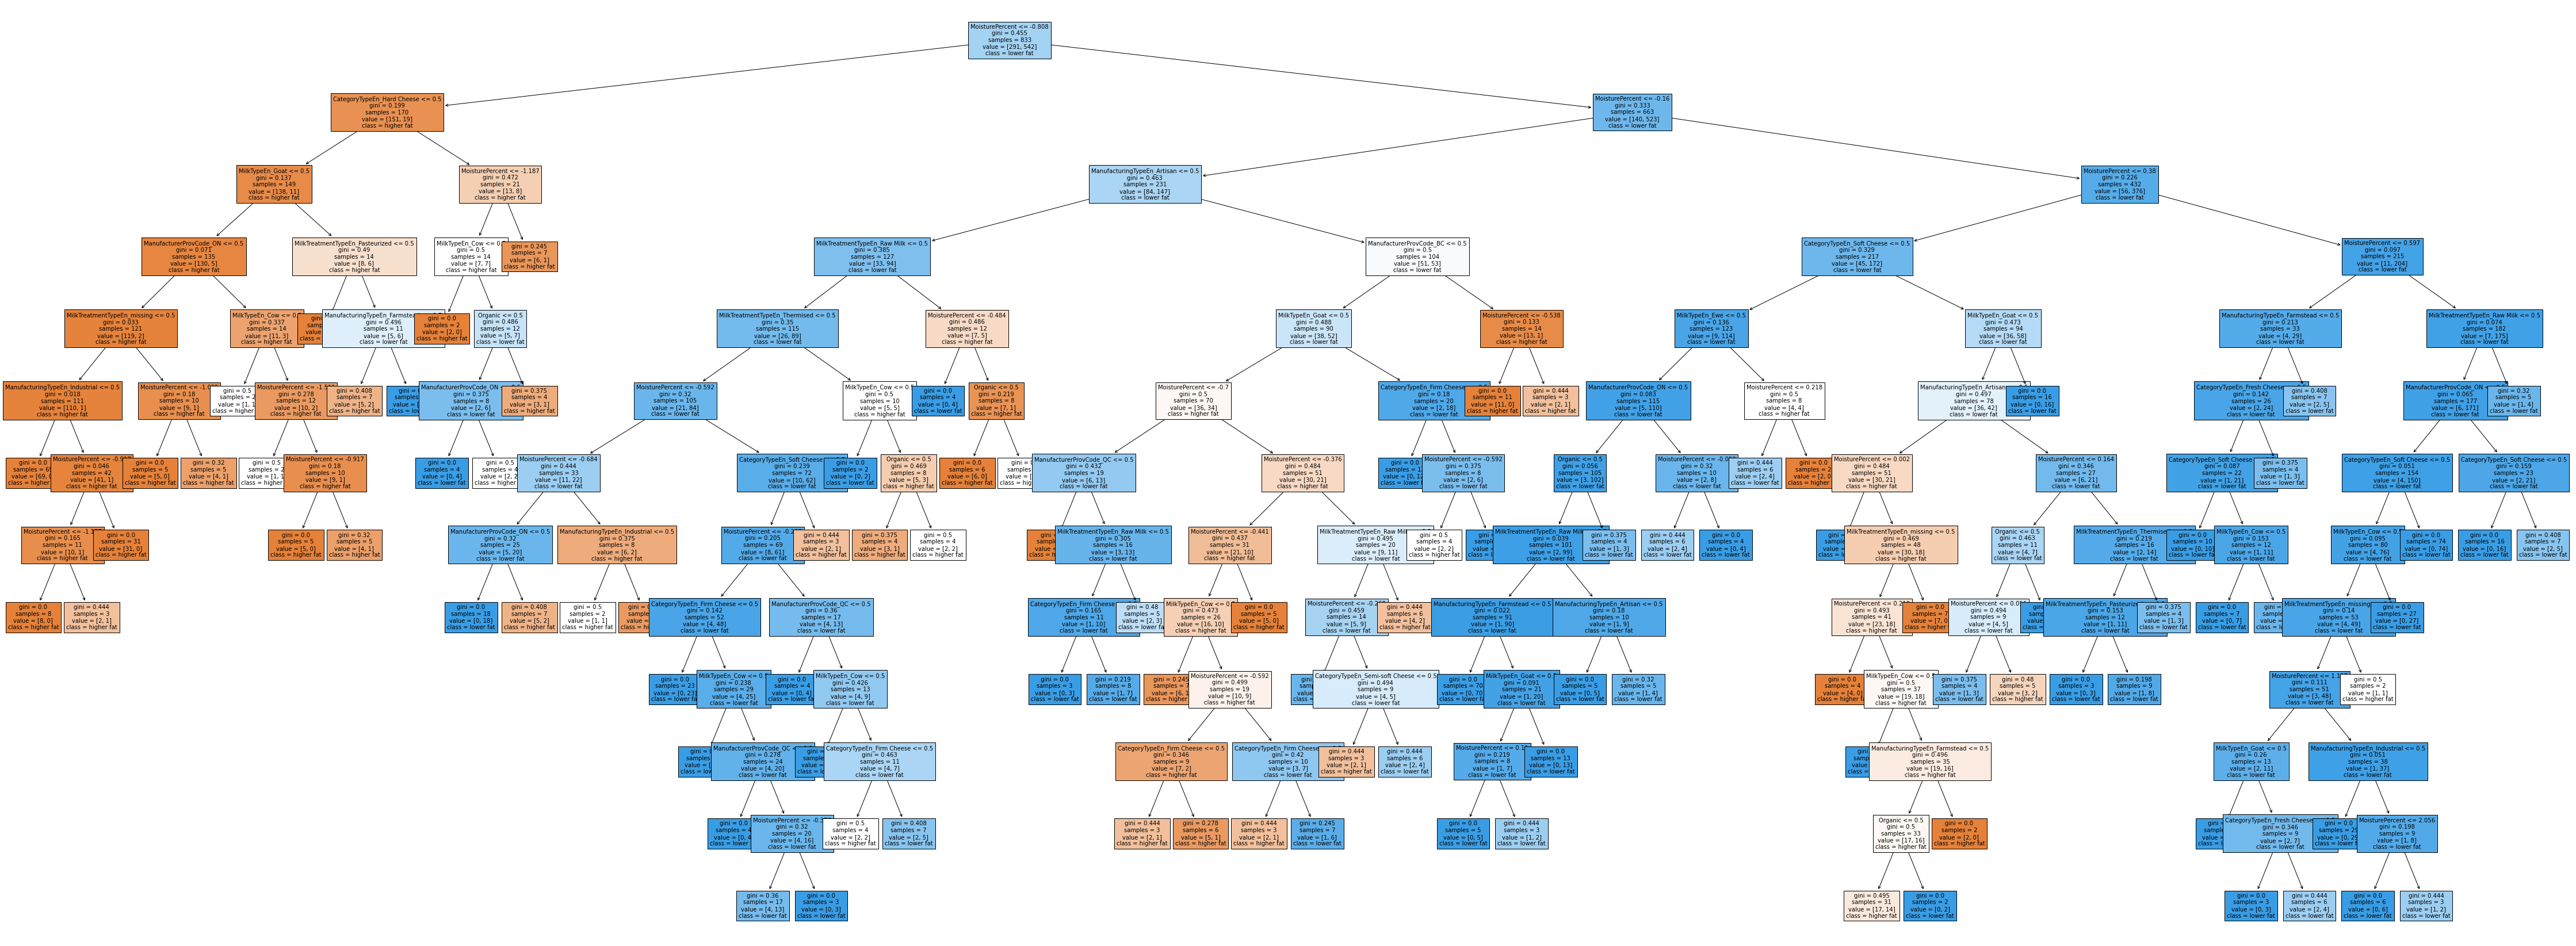

In [36]:
best_dt_classifier = DecisionTreeClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=8, random_state=42)

final_pipeline = make_pipeline(
    preprocessor,
    best_dt_classifier
)

final_pipeline.fit(X_train, y_train)

# new_cat_cols = final_pipeline.named_steps['columntransformer'].named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names(categorical_features)
# feature_list = np.concatenate([numeric_features, new_cat_cols, binary_features])
plt.figure(figsize=(80,30))
plot_tree(final_pipeline.named_steps['decisiontreeclassifier'], feature_names=feature_list, filled=True, class_names=final_pipeline.named_steps['decisiontreeclassifier'].classes_, fontsize=10)
plt


In [37]:
final_pipeline.classes_

array(['higher fat', 'lower fat'], dtype=object)

Double click the image to read everything. Visually this is quite interesting as the colours (and mixtures of colours) represent the different class distinctions. The first leaf of the decision tree is based on mosture percent - which the logistic regression model also picked out as having most significance.

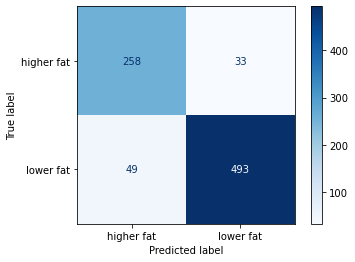

In [38]:
dt_confion_matrix = plot_confusion_matrix(final_pipeline, X_train, y_train, display_labels=['higher fat','lower fat'], values_format='d', cmap='Blues')
dt_confion_matrix

In [39]:
dt_accuracy_score = (493+258)/833
dt_accuracy_score

0.9015606242496998

The accuracy was higher then the mean cross validation score (82.5%)

##### For this matrix, the positive class is the lower fat.
The confusion matric shows:
- True Negative (true:higher fat, predicted:higher fat) of 258 (a significant improvement over logistic regressions 167) - The negative class which we predicted correctly.
- True Positive (true:lower fat, predicted:lower fat) of 493 (slightly less then the logistic regression model - 501) - The positive class which we predicted correctly.
- False Positives (true:higher fat, predicted:lower fat) of 33 (significantly less (and better for health concerns (if we are concerned about higher fat cheeses being classified mistakenly as lower fat cheeses) then the 124 the logistic regression model predicted) - The positive class which we predicted incorrectly.
- False Negatives (true:lower fat, predicted:higher fat) of 49 (compared to 41 from the logistic regression model) - The negative class which we predicted incorrectly.

The model correctly predicts a significant amount of lower fat 493 out of 542 - this is about 91% (compared to 93% from the logistic regression model) which is also quite good. The model does significantly better with predicting the higher fat examples over the logistic regression model - correctly predicting 258 out of 291 (much better then the logistic regression model which correctly predicted 167 out of 291 ~57%) - with the decision tree coming in at about ~92% accuracy. Given that the model is tuned for accuracy, this is pretty good and does better then the logistic regression model. As previously discussed, if the model was to assist in dietary needs, and therefore had health implications, I would have focussed more on recall in the hyper parameter tuning stage. The decision tree model is a better choice for both acccuracy and recall.

Comparing this model to the logisistic regression, the decision tree handles this problem better overall then the logistic regression model.

Lets take a look at both matrices side by side.

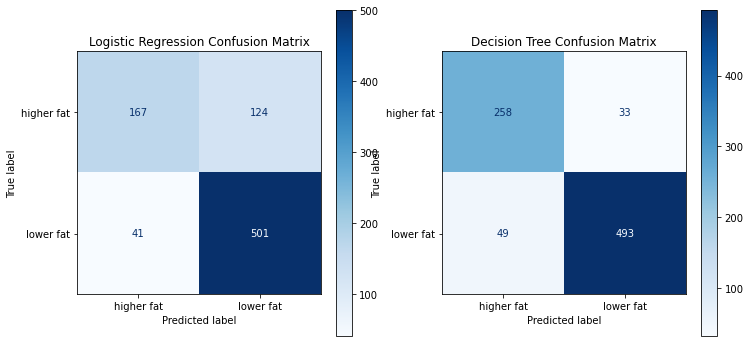

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
lr_confusion_matrix.plot(ax=plt.gca(),values_format='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.subplot(1, 2, 2)
plt.title('Decision Tree Confusion Matrix')
dt_confion_matrix.plot(ax=plt.gca(),values_format='d', cmap='Blues')


Based on my scoring preference of accuracy, I am going to choose the decision tree as my final model.

Lets use the final_pipeline to predict against the test data.

In [41]:
y_pred_test = final_pipeline.predict(X_test)

Lets look at the scores of the model.

In [42]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, pos_label='lower fat')
recall = recall_score(y_test, y_pred_test, pos_label='lower fat')
f1 = f1_score(y_test, y_pred_test, pos_label='lower fat')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8564593301435407
Precision: 0.9242424242424242
Recall: 0.8591549295774648
F1 Score: 0.8905109489051095


I am happy with each of these metrics. The model has performed well.

Lets see how the confusion matrix looks

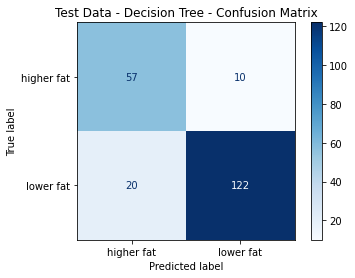

In [50]:
confusion_matrix = plot_confusion_matrix(final_pipeline, X_test, y_test, display_labels=['higher fat', 'lower fat'], cmap=plt.cm.Blues, normalize=None)
confusion_matrix.ax_.set_title('Test Data - Decision Tree - Confusion Matrix')
plt.show()


Since this is a smaller dataset, the model might decrease in accuracy as the dataset increases in size.


- True Negative (true:higher fat, predicted:higher fat) of 57 - The negative class which we predicted correctly.
- True Positive (true:lower fat, predicted:lower fat) of 122 - The positive class which we predicted correctly.
- False Positives (true:higher fat, predicted:lower fat) of 10 - The positive class which we predicted incorrectly.
- False Negatives (true:lower fat, predicted:higher fat) of 20 - The negative class which we predicted incorrectly.



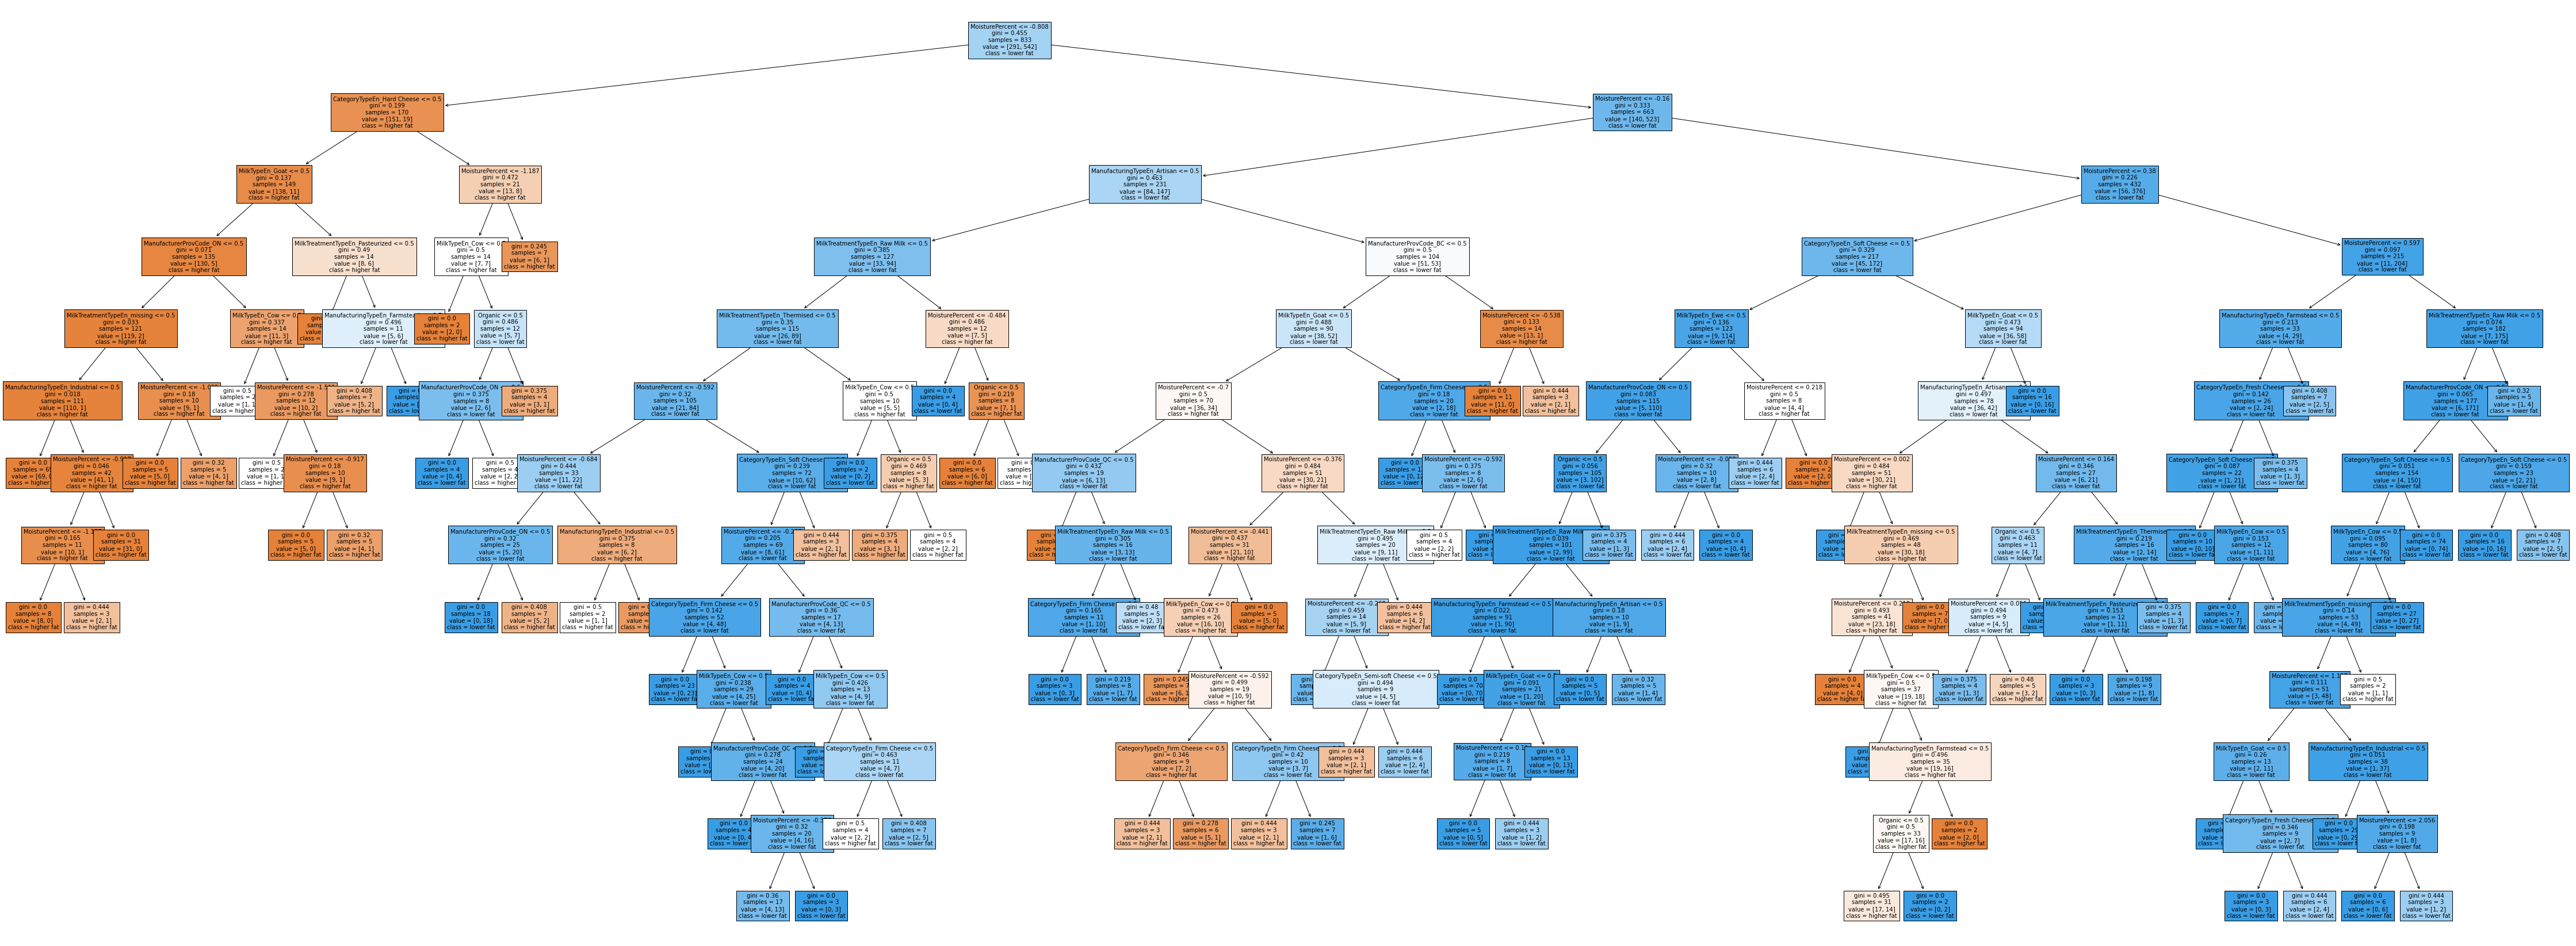

In [44]:
plt.figure(figsize=(80,30))
plot_tree(final_pipeline.named_steps['decisiontreeclassifier'], feature_names=feature_list, filled=True, class_names=final_pipeline.named_steps['decisiontreeclassifier'].classes_, fontsize=10)
plt.show()

We can double click the decision tree to see the splits. Interestingly, the decision tress first step is [MoisturePercent <=0.808] - which shows that the decision tree also values this feature highly, similar to the logistic regression model.

The decision tree, although not as interpretable as the logistic regressions coefficiencts, is nicely displayed in the visual above, allowing you to understand some of the important distinctions the tree makes early on, allowing you to interpret the data.

The results provide an acceptable level of accuracy and interpretability doing a lot better then a dummy classifier and providing some interesting insights to the data.

The final results still show moisture percentage to be one of the most important factors when looking to classify high or low fat cheese. Interestingly, also whether the cheese is hard or soft seems to make a significant difference as we see it higher up the decision tree.

## Limitations of the Model, Potential sources of bias or data quality issues

Some limitations of this model included
- missing values - these were imputed in appropriate ways and imputing in otherways may change the results.
- imbalanced dataset - the higher fat dataset only made  up about 1/3 of the data. 
- limited amount of features - as discussed below, after researching cheese a little, it might be interesting to look to add features such as varieties of cheesse as well as using count vectorizer for some of the columns in the original dataframe.





I realised pretty early on exploring this data that the MilkTypeEn was unbalanced for the 'Cow' class (shown below). This suggests that Canadian dairy industry produces more cow cheeses then any other. However, this might not be the same world-wide and if we wanted a 'global' cheese predicting model, rather then a Canadian cheese predicting model, it might be worth considering creating a seperate model for each MilkTypeEn class on its own to provide more accuracte predictions and looking at data from over the world. This would require a larger dataset, particularly as some of the classes have very few observations. 


In [45]:
fat_level_counts.sort_values(by='High Fat Ratio %', ascending=False)

FatLevel           higher fat  lower fat  High Fat Ratio %
MilkTypeEn                                                
Ewe and Cow                 3          1             75.00
Ewe and Goat                1          1             50.00
Cow                       297        446             39.97
Ewe                        24         38             38.71
Cow and Goat                3         10             23.08
Goat                       29        185             13.55
Buffalo Cow                 0          2              0.00
Cow, Goat and Ewe           0          1              0.00

The Wikipedia article https://en.wikipedia.org/wiki/Types_of_cheese - describes how cheeses are classified (which seems to be quite subjective and contenscious!) as follows:

*The combination of types produces around 51 different varieties recognized by the International Dairy Federation over 400 identified by Walter and Hargrove, over 500 by Burkhalter, and over 1,000 by Sandine and Elliker. Some attempts have been made to rationalise the classification of cheese; a scheme was proposed by Pieter Walstra that uses the primary and secondary starter combined with moisture content, and Walter and Hargrove suggested classifying by production methods. This last scheme results in 18 types, which are then further grouped by moisture content.*



The following chart taken from the WayBackMachine (https://web.archive.org/web/20111124103458/http://www.egr.msu.edu/~steffe/handbook/tbl141.html) - attributed to dairyscience.info - see references for more details.
Interestingly, it seems as though there have been attempts to classify terms like 'Hard' and 'Soft' - which means that this could be an interesting feature to explore.

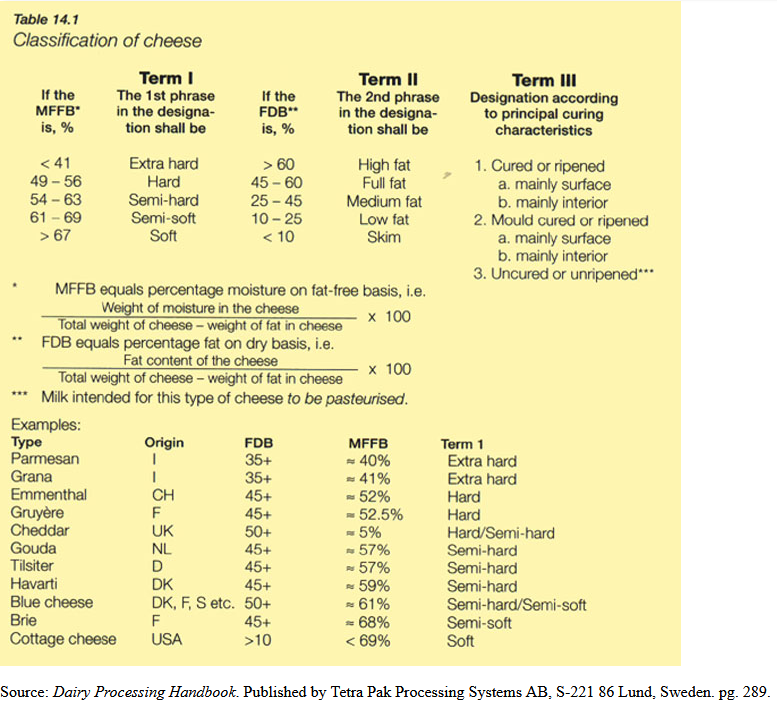

In [46]:
from IPython.display import Image
Image(filename='img/CheesesClassifications.png')

Given the new knowledge gained from Wikipedia, it might even be worth expanding the dataset to include the feature cheese_variety. I suspect this may be an interesting feature to explore but would also require some thought on how to implement.

## Ideas that you did not try but could potentially improve the performance/interpretability

Using count vectorizer to FlavourEn and CharacteristicsEn may provide insights such as specific word features being associated with 'higher' or 'lower' fat.

Creating seperate models for the MilkTypeEn classes might provide better scores for the prediction - however, it would require a larger dataset for all the classes.

Increasing the cheese dataset to a global range and expanding the dataset to types of cheese also. I would expect to see that various types of cheese have predictable bands of fat ranges.

It might also be interesting to get the numeric values of fat percentage and instead of using a classifier, use logistic regression to try and predict the fat percentage of the cheese instead. Afterall, 'high' and 'low' classes are not as descriptive as a numeric fat % representation.

## References
Refer to the Types of cheese (https://en.wikipedia.org/wiki/Types_of_cheese) Wikipedia page for details on cheese varieties and classifications.

Classification of Cheese image
    - dairyscience.info >> https://web.archive.org/web/20111124103458/http://www.egr.msu.edu/~steffe/handbook/tbl141.html 

Include well-cited and appropriate references for any code or content used from the module or external sources. Each reference should be accurately formatted, providing complete details for readers to locate the original sources easily